<a href="https://colab.research.google.com/github/romeoVh/KFUPM_Teaching/blob/main/CIE483_Lecture_7_CIFAR_10_and_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks with Keras and TensorFlow

**Ramy Rashad (KFUPM)**

**Resources: [Daniel Moser](https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb#scrollTo=Hs3ufCQvObnI), [Devashree Madhugiri](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fcode%2Frutvikdeshpande%2Ffashion-mnist-cnn-beginner-98), [Roblex Nana](https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer)** **[Amy Jang](https://www.kaggle.com/code/amyjang/tensorflow-cifar10-cnn-tutorial)**

*To* help you understand the fundamentals of convolutional neural networks, this demo will walk through the basic steps of building CNN models for classifying RGB- images.

Make sure to choose **GPU as Runtime** as this tutorial will be computationally more involved than last time.

Last lecture, we saw how to build a fully-connected feedforward neural network that accepts the normalized pixel values of an image and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

For example, in the illustration below a 3x3 kernel (yellow) is convolved over a 5x5 image (green).
A dot product operation takes place between the image and the kernel and the convolved feature (red) that is encoded in the kernel is generated.
<img src='https://github.com/romeoVh/KFUPM_Teaching/blob/main/img/convolutions_illustration.gif?raw=1'>

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc. These operations are implemented using pre-designed kernels. The main idea in Convolutional Neural Networks (CNNs) is that we will learn these kernels through supervised learning.

<img src='https://github.com/romeoVh/KFUPM_Teaching/blob/main/img/convolution_filter_examples.png?raw=1'>


## The Task for the AI agent

In this tutorial, we will design CNNs for an image classification task of the CIFAR-10 dataset. CIFAR-10 is a very popular computer vision dataset provided by the Canadian Institute For Advanced Research (CIFAR). This dataset is used in many types of deep learning research for object recognition. Details about the CIFAR-10 dataset are available [here](https://www.cs.toronto.edu/~kriz/cifar.html).

<img src='https://github.com/romeoVh/KFUPM_Teaching/blob/main/img/cifar-10.png?raw=1'>

The dataset has 60,000, 32x32 color images from 10 classes, with 6000 images from each class. The training dataset contains 50,000 training images and the test dataset contains 10,000 test images.

The CIFAR-10 dataset images are of color images with a (32 x 32) resolution. All the images in the dataset are of shape (32,32,3) where 3 represents the number of channels i.e R-G-B (Red,Green & Blue).

## Prerequisite Python Modules

Let's start by importing all required libraries and the dataset.





In [ ]:
%matplotlib inline
!apt-get install  visualkeras
!pip install visualkeras

import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import time
import seaborn as sns

from IPython.display import Image, display

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, Activation,BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical,plot_model
import visualkeras

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package visualkeras
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 31.5 MB/s eta 0:00:00


## Loading Training Data

The Keras dataset module already comes with the CIFAR-10 dataset. So,we can directly import it using the `keras.datasets` command.
Then let's checkout a random sample of images.

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


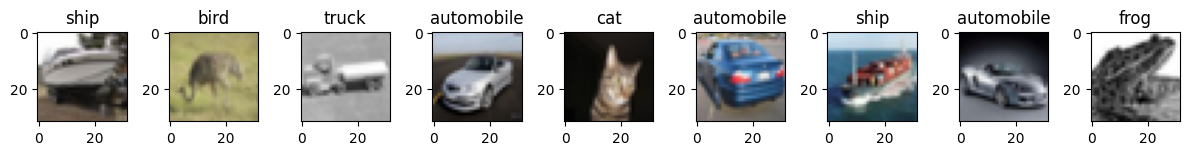

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

plt.rcParams['figure.figsize'] = (12,12) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(1,9,i+1)
    num = random.randint(0, len(train_images))
    plt.imshow(train_images[num])
    plt.title(class_names[train_labels[num][0]]) # The CIFAR labels happen to be arrays, which is why you need the extra index

plt.tight_layout()

We have to normalize the data in order to reduce the pixel values. Currently, all the image pixels are in a range from 0–255, and we want the values in the range of 0 and 1. So we  divide all the pixel values by 255.0.

Furthermore, the labels for the training and the testing dataset are currently categorical and is not continuous. To include categorical dataset in our model, our labels should be converted to one-hot encodings.

For example, 2 (bird) becomes `[0,0,1,0,0,0,0,0,0,0]` and 7 (horse) becomes `[0,0,0,0,0,0,0,1,0,0]`.



In [ ]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# One-Hot-Encoding
train_labels_en = to_categorical(train_labels,10)
test_labels_en = to_categorical(test_labels,10)

print(train_labels_en.shape)
print(test_labels_en.shape)

(50000, 10)
(10000, 10)


# Basic CNN model

Now it’s time to build our model. We are going to use a Convolution Neural Network (CNN) to train our model. It includes:


1.   Convolution or Conv2D Layer: A convolution layer is used to extract features from the image or part of an image. Here, we are defining three parameters:

  * Filters — It refers to the number of filters to be applied in the convolution. Eg. 32 or 64.

  * Kernel_size — It refers to the length of the convolution window. Eg. (3,3) or (4,4).
  * Activation — It refers to the regularizer function. Eg. ReLU, Leaky ReLU, Tanh, Sigmoid.

2.   Pooling or MaxPooling2D Layer: In this layer, we are scaling down the size of an image. We are keeping the size (2,2) for the pooling layer.

3. Flatten Layer: This layer converts the n-dimensional array to 1 dimensional array.

4. Dense Layer: This layer is a fully connected layer i.e.all the neurons in the current layer are connected to the next layer. For our model, we are setting the first dense layer with 128 neurons and the second dense layer with 10 neurons.



In [ ]:
# Base Model
model_1 = Sequential([
    Conv2D(32,(4,4),activation='relu',input_shape = (32,32,3)),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(32,(4,4),activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Flatten(),
    Dense(128, activation ='relu'),
    Dense(10, activation ='softmax')
])

model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 29, 29, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,802 (475.79 KB)

 Trainable params: 121,802 (475.79 KB)

 Non-trainable params: 0 (0.00 B)

**Question:** How to compute memory size mentioned above in KB ?

**Hint: **`float32` (32-bit floating point) variable takes 4 bytes of memory (since 32 bits = 4 bytes)

**Answer:** ...

There are many packages available to visualize neural network architectures which is very important for sanity checks, debugging, and sharing your work.
The `visualkeras` package is one of them and is used as follows:

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


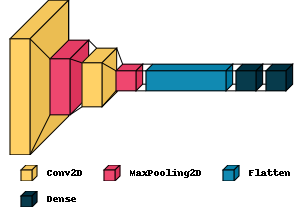

In [ ]:
output_file = '/content/output_model_1.png'
visualkeras.layered_view(model_1, legend=True, to_file=output_file) # write to file
display(Image(output_file, width=500)) # display image


Now we are ready to train our model. As this model aims to categorize the images, we will use a `categorical_crossentropy` loss function and the `adam` optimizer.

The trainning is done within the `fit()` function which takes the training and test data to fit our model.
We also need to specify for it:
- **Batch_size:** The number of samples selected from the training set to compute the gradients and update the model's weights.
- **Epochs:** Number of times we are passing the complete dataset forward and backward through the neural network.
- **Verbose:** options to view our output. Eg. verbose = 0 will print nothing, verbose = 1 will print the progress bar and one line per epoch while verbose = 2 will print one line per epoch.




In [ ]:
model_1.compile(loss ='categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])

# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 128
EPOCHS = 40

# Record the start time
start_time = time.time()

# Start the Training
history_1 = model_1.fit(train_images, train_labels_en, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")



Epoch 1/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3245 - loss: 1.8437
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5260 - loss: 1.3345
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5851 - loss: 1.1923
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6152 - loss: 1.0958
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6377 - loss: 1.0432
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6575 - loss: 0.9831
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6738 - loss: 0.9364
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6916 - loss: 0.8870
Epoch 9/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7077 - loss: 0.8410
Epoch 10/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7181 - loss: 0.8046
Epoch 11/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7346 - loss: 0.7722
Epoch 12/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

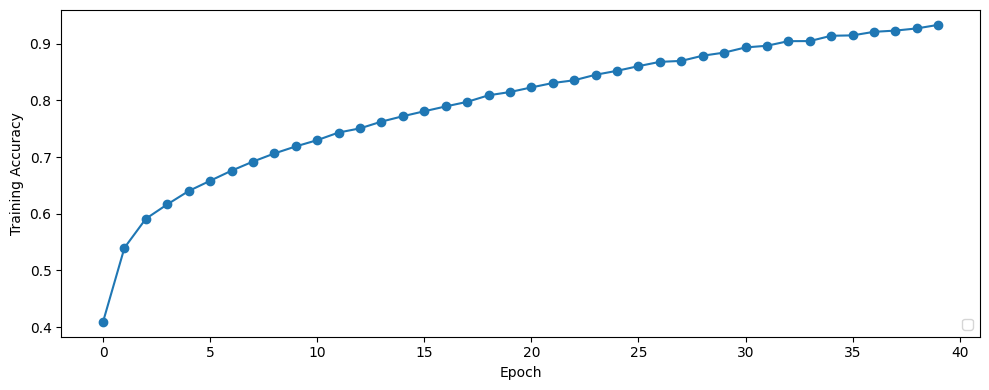

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_1.history['accuracy'],'-o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()

Now let's check our model's performance when applied to the test dataset.

In [ ]:
test_loss, test_acc = model_1.evaluate(test_images,  test_labels_en, verbose=2)
print('Test accuracy',test_acc)

313/313 - 2s - 5ms/step - accuracy: 0.6682 - loss: 1.6669
Test accuracy 0.6682000160217285


# Regularization Techniques

After running our basic model for several epochs, it is giving good results on the training data set but fails to do so on the test data. This is a result of overfitting.
**Overfitting** occurs when a model learns not only the underlying patterns in the training data but also the noise and irrelevant details, which leads to poor generalization to new, unseen data.

In deep learning, **regularization** refers to techniques used to prevent overfitting by adding constraints to the learning process.

Common regularization techniques include:



1.   **Early Stopping:**

During training, the model is evaluated on a validation set after each epoch. If the model’s performance on the validation set stops improving or starts degrading, training is halted. This prevents the model from overfitting by stopping before it over-trains.

2.   **Dropout:**

A technique where a fraction of neurons is randomly "dropped" (i.e., set to zero) during each training iteration. This forces the network to learn more robust and distributed representations since it cannot rely on any specific neurons.
Dropout is only applied during training and is turned off during testing.

3. **Batch Normalization:**

A technique that normalizes the output of activation layers using the mean and variance of the current batch of data.
During training, the distribution of activations (outputs of neurons) can change as the model's weights are updated, making it harder for the model to converge. This phenomenon is called **internal covariate shift**. Batch normalization reduces this shift by normalizing the activations, making training more stable, avoid overfitting, and allowing for faster convergence.


4. **Data Augmentation:**

This involves artificially increasing the size of the training set by applying transformations like rotations, flips, and scaling to the original data. This helps the model generalize better by providing more varied training samples.



# Advanced CNN model

Now let's build a more complex CNN with multiple convolution layers combined with batch normalization in addition to a drop-out layer within the final fully connected network. Furthermore, we will implement data augmentation layers before the network which will randomly flip some images horizontally and shift them by 20 % vertically and horizontally.

Note that in Keras, when you apply data augmentation using functions like `RandomFlip` and `RandomTranslation`, the augmentation is only applied during training and is automatically turned off during testing (inference). This is because the purpose of data augmentation is to artificially expand the training dataset and help the model generalize better. During testing, we want to use the model's exact learned parameters without introducing additional randomness.



In [ ]:
data_aug_layers = Sequential([
    # Data augmentation layers
    keras.layers.RandomFlip("horizontal"),              # Random horizontal flip
    keras.layers.RandomTranslation(0.2, 0.2),           # Random horizontal and vertical shifts (20%)
],name = 'augment_data')


model_2 = Sequential()                                 # Linear stacking of layers

model_2.add(Input(shape=(32,32,3)))
model_2.add(data_aug_layers)
#model_2.add(keras.layers.RandomFlip("horitzontal"))
#model_2.add(keras.layers.RandomRotation(0.2))

# Convolution Layer 1
model_2.add(Conv2D(32, (3, 3))) # 32 different 3x3 kernels -- so 32 feature maps
model_2.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model_2.add(convLayer01)

# Convolution Layer 2
model_2.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model_2.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model_2.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model_2.add(convLayer02)

# Convolution Layer 3
model_2.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model_2.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model_2.add(convLayer03)

# Convolution Layer 4
model_2.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model_2.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model_2.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model_2.add(convLayer04)
model_2.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model_2.add(Dense(512))                                # 512 FCN nodes
model_2.add(BatchNormalization())                      # normalization
model_2.add(Activation('relu'))                        # activation

# Fully Connected Layer 6
model_2.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes during training
model_2.add(Dense(10))                                 # final 10 FCN nodes
model_2.add(Activation('softmax'))                     # softmax activation
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ augment_data (Sequential)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │              

 Total params: 893,226 (3.41 MB)

 Trainable params: 891,818 (3.40 MB)

 Non-trainable params: 1,408 (5.50 KB)

**Note** the size and number of parameters of the advanced CNN model in comparison to the basic CNN model we build before.

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


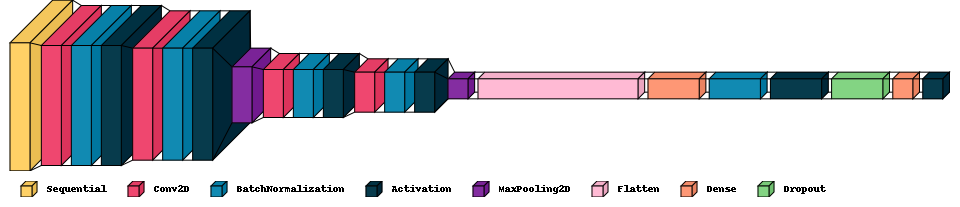

In [ ]:
#plot_model(model_2, to_file='/content/model_2.png')
output_file = '/content/output_model_2.png'
visualkeras.layered_view(model_2, legend=True, to_file=output_file).show() # write and show
display(Image(output_file, width=1300))


Now let's train this new model and see its performance.

In [ ]:
model_2.compile(loss ='categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 128
EPOCHS = 20

# Record the start time
start_time = time.time()

# Start the Training
history_2 = model_2.fit(train_images, train_labels_en, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

# Record the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.3707 - loss: 1.7746
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.5538 - loss: 1.2434
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6191 - loss: 1.0718
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6557 - loss: 0.9690
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6822 - loss: 0.8984
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6966 - loss: 0.8547
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7132 - loss: 0.8119
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7231 - loss: 0.7848
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7341 - loss: 0.7579
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7395 - loss: 0.7332
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7567 - loss: 0.6998
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━

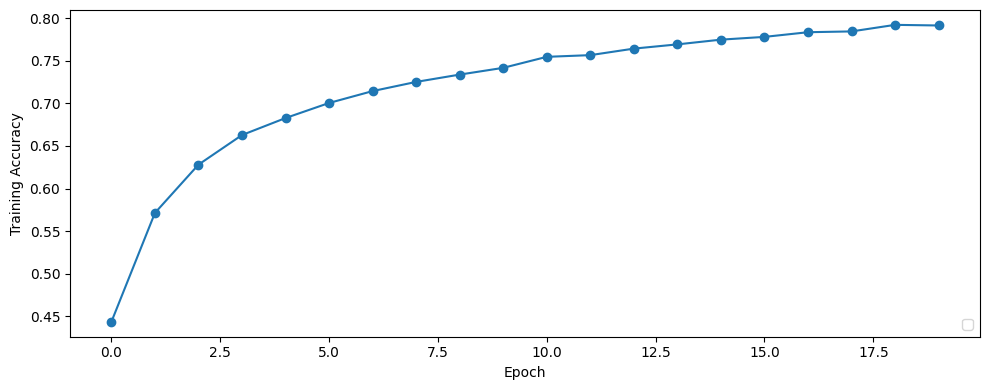

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_2.history['accuracy'],'-o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()

In [ ]:
test_loss, test_acc = model_2.evaluate(test_images,  test_labels_en, verbose=2)
print('Test accuracy',test_acc)

313/313 - 1s - 5ms/step - accuracy: 0.7754 - loss: 0.6459
Test accuracy 0.7753999829292297


## Confusion matrix

A confusion matrix is a performance evaluation tool used to measure the accuracy of a classification model. It provides insight into how well a classifier is performing by showing a breakdown of the correct and incorrect predictions for each class. The matrix shows not only the number of correct predictions but also the types of errors the classifier is making.




313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[[Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')],
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')]]

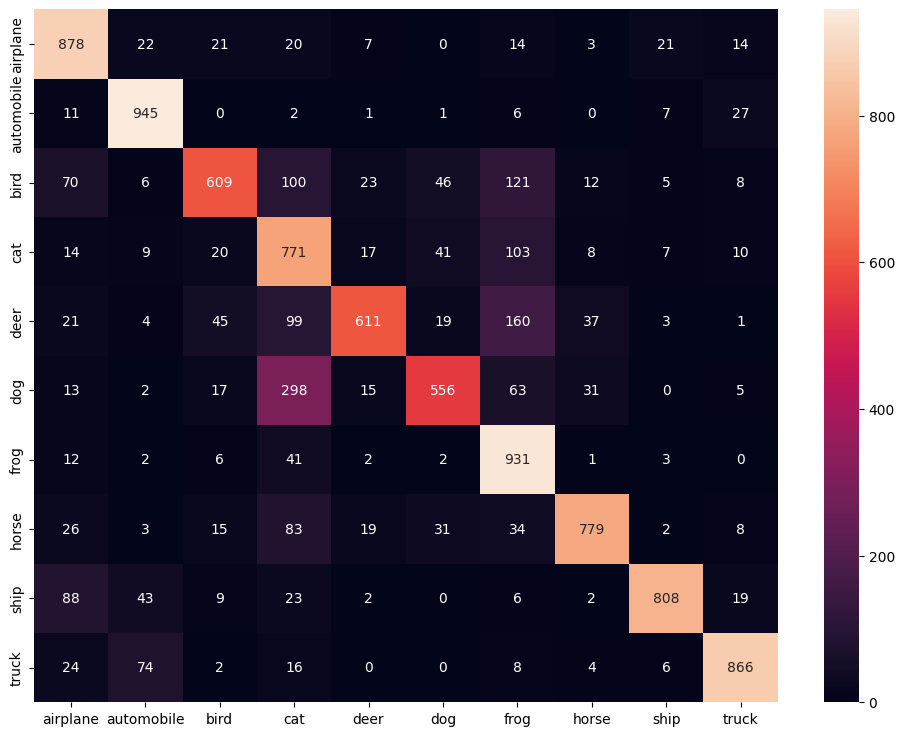

In [ ]:
# Predict the values from the validation dataset
predict_labels = model_2.predict(test_images)
# Convert predictions classes to one hot vectors
predict_classes = np.argmax(predict_labels,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(test_labels, predict_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=class_names, yticklabels=class_names)


Now let's visualize some of our classifier's correct and incorrect results:

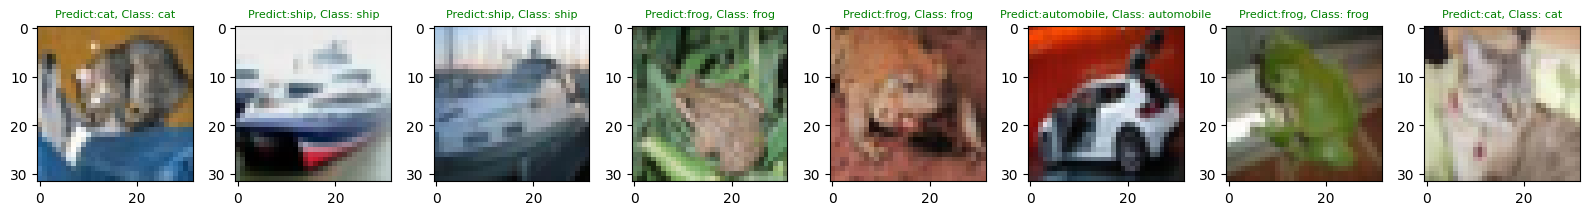

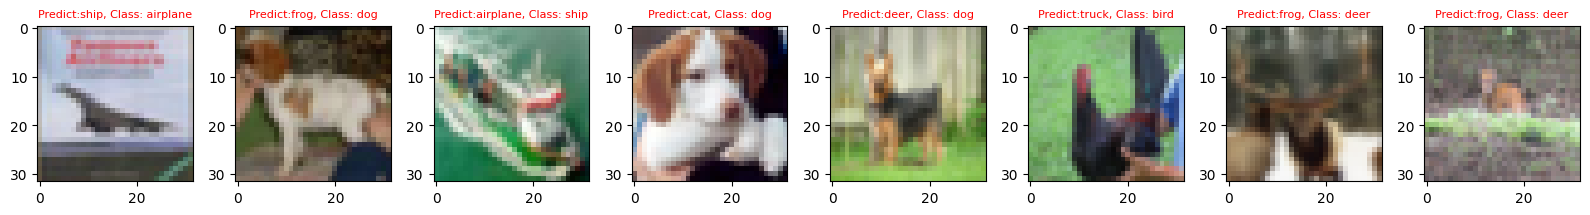

In [ ]:
# Reshape labels from size (10000,1) to (10000,) to match predict_classes
test_labels = test_labels.reshape(-1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predict_classes == test_labels)[0]
incorrect_indices = np.nonzero(predict_classes != test_labels)[0]


plt.rcParams['figure.figsize'] = (16,16) # Make the figures a bit bigger

plt.figure()
for i, correct in enumerate(correct_indices[:8]):
    plt.subplot(1,8,i+1)
    plt.imshow(test_images[correct])
    plt.title("Predict:" + class_names[predict_classes[correct]] + ", Class: " + class_names[test_labels[correct]],color = 'green', fontsize=8)


plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:8]):
    plt.subplot(1,8,i+1)
    plt.imshow(test_images[incorrect])
    plt.title("Predict:" + class_names[predict_classes[incorrect]] + ", Class: " + class_names[test_labels[incorrect]],color = 'red', fontsize=8)

plt.tight_layout()


# Other CNN architectures

https://github.com/BIGBALLON/cifar-10-cnn
